In [3]:
"""
Logging for the whole notebook
"""

import logging
import time


logger = logging.getLogger(__name__ + str(time.time()))        # current file name + time for the logger, avoid duplicate
logger.setLevel(logging.DEBUG)
logger.propagate = False                                        # avoid duplicate output
fmt = logging.Formatter("%(asctime)s - %(levelname)s - %(filename)s - PID:(process)d - TID:%(thread)d - %(message)s")
handler = logging.StreamHandler()
handler.setFormatter(fmt)
logger.addHandler(handler)

logger.debug("Initialization of logger completed.")

2025-07-04 17:48:12,201 - DEBUG - 879181675.py - PID:(process)d - TID:8784977664 - Initialization of logger completed.


In [4]:
"""
Mlflow Setup
"""



2025-07-04 17:48:13,119 - DEBUG - 1791494338.py - PID:(process)d - TID:8784977664 - [ALL] Train dataset size: 50000


2025-07-04 17:48:14,229 - DEBUG - 2219108188.py - PID:(process)d - TID:8784977664 - [SMALL] Train dataset size: 100
2025-07-04 17:48:14,230 - DEBUG - 2219108188.py - PID:(process)d - TID:8784977664 - Number of classes: 100


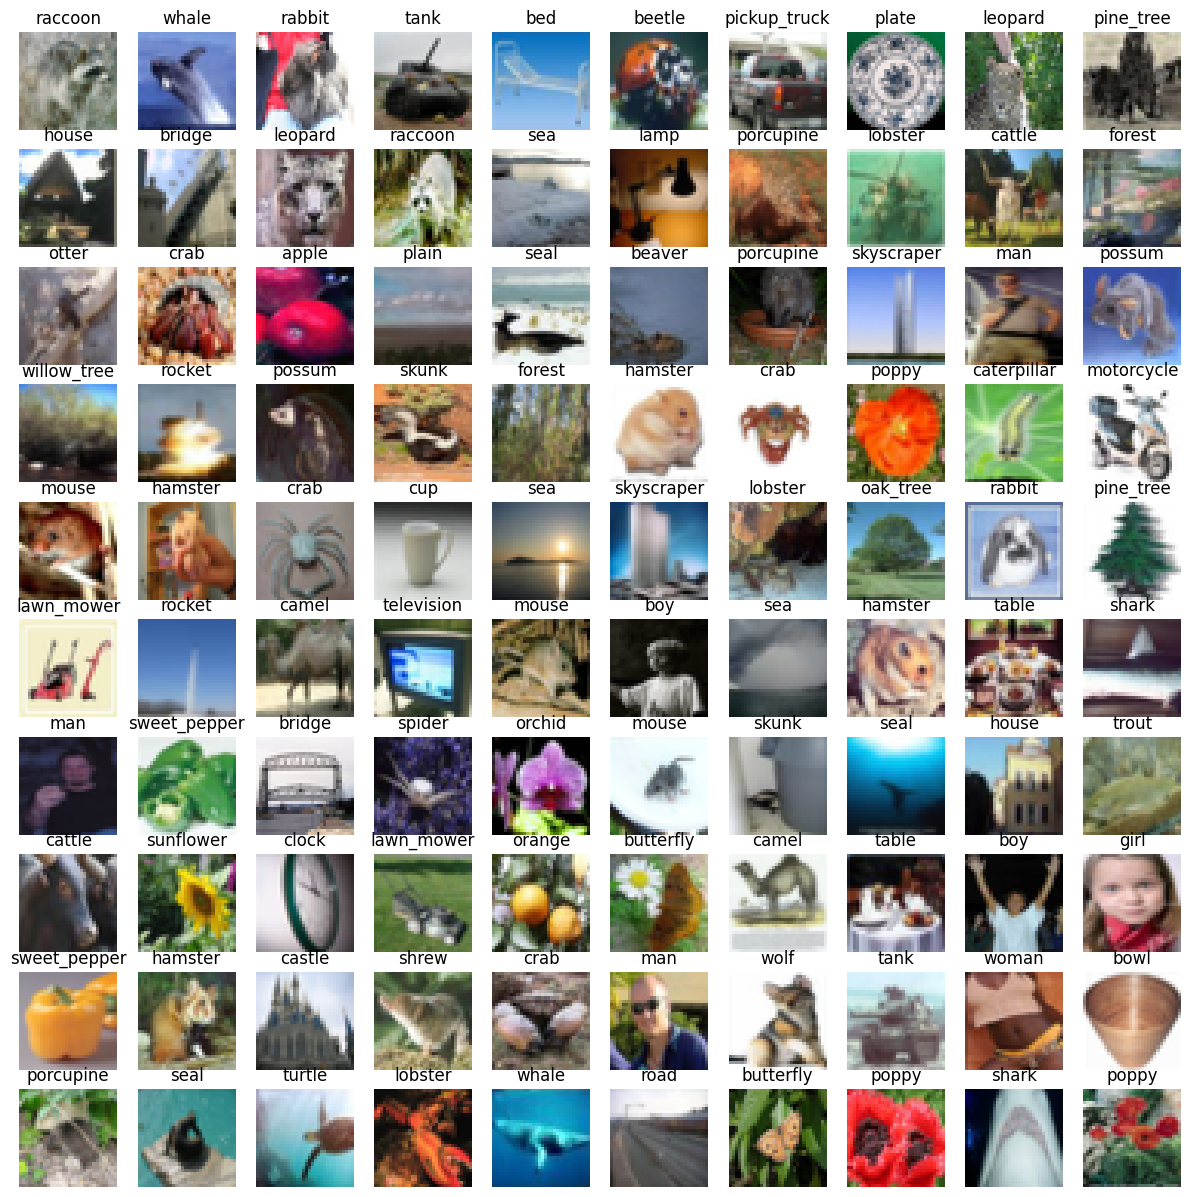

In [5]:
"""
1. Data Importation
"""
from torchvision.datasets import CIFAR100
from pathlib import Path

project_root = Path.cwd().parent
data_root = project_root / "data"

train_ds = CIFAR100(root=data_root)

logger.debug(f"[ALL] Train dataset size: {len(train_ds)}")



In [25]:
"""
2. Data analysis & Display
"""
from torch.utils.data import Subset
import matplotlib.pyplot as plt

train_ds_small = Subset(train_ds, range(800, 900))
logger.debug(f"[SMALL] Train dataset size: {len(train_ds_small)}")

all_classes = train_ds_small.dataset.classes
logger.debug(f"Number of classes: {len(all_classes)}")

fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(15, 15))
for idx, (image_tensor, cls_num) in enumerate(train_ds_small):
    row, col = idx // 10, idx % 10
    axes[row, col].imshow(image_tensor)
    axes[row, col].set_title(f"{all_classes[cls_num]}")
    axes[row, col].axis("off")      # remove axis to avoid overlapping


In [32]:
"""
3. Data Preprocessing
"""

from torchvision import transforms

train_tf = transforms.Compose([
    transforms.Resize((224, 224)),          # ViT expected 224 x 224
    transforms.RandomHorizontalFlip(0.5),   # 0.5 chance to flip the image horizontally
    transforms.ToTensor(),                  # from image to pytorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [33]:
"""
4. Model Definition
"""

from torch import nn
from torchvision.models import vit_b_16, ViT_B_16_Weights     # Vision Transformer in Base 16

class MyViTBase16(nn.Module):
    def __init__(self, epoch_num=10, batch_size=64, learning_rate=1e-4, use_mlflow=True):
        super().__init__()
        self._model = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)      # import ViT with pre-trained weights

        # Hyper Parameters
        self._batch_size = batch_size
        self._learning_rate = learning_rate

    def


m = MyViTBase16()






2025-07-04 18:03:07,552 - INFO - 553326047.py - PID:(process)d - TID:8784977664 - Initializing ViT-B/16 with 100 classes
2025-07-04 18:03:09,497 - INFO - 553326047.py - PID:(process)d - TID:8784977664 - Model loaded on mps
2025-07-04 18:03:09,499 - INFO - 553326047.py - PID:(process)d - TID:8784977664 - Starting training for 1 epochs
2025-07-04 18:03:09,541 - ERROR - 1797993113.py - PID:(process)d - TID:8784977664 - slow_conv2d_forward_mps: input(device='cpu') and weight(device=mps:0')  must be on the same device
2025-07-04 18:03:09,640 - ERROR - 553326047.py - PID:(process)d - TID:8784977664 - Training failed: Placeholder storage has not been allocated on MPS device!
2025-07-04 18:03:09,718 - INFO - 553326047.py - PID:(process)d - TID:8784977664 - Training completed: 0.0min, Best: -1.0000


🏃 View run 20250704_180309 at: http://127.0.0.1:5555/#/experiments/6/runs/d1dc112ab8ee43b5a2428f75f68d1ccb
🧪 View experiment at: http://127.0.0.1:5555/#/experiments/6
🏃 View run marvelous-mouse-428 at: http://127.0.0.1:5555/#/experiments/6/runs/a324033ec2684805b0b89fffb0107c94
🧪 View experiment at: http://127.0.0.1:5555/#/experiments/6


RuntimeError: Placeholder storage has not been allocated on MPS device!

In [ ]:
import psutil

"""
System & Environment information
"""

import platform
import torch
import torchvision

def get_system_info():
    """
    Collect system and environment information
    """
    return {
        "python_version": platform.python_version(),
        "pytorch_version": torch.__version__,
        "torchvision_version": torchvision.__version__,
        "cuda_version": torch.version.cuda if torch.cuda.is_available() else "N/A",
        "cudnn_version": torch.backends.cudnn.version() if torch.cuda.is_available() else "N/A",
        "platform": platform.platform(),
        "cput_count": psutil.cpu_count(),
        "memory_total_gb": round(psutil.virtual_memory().total / 1024 ** 3, 2)      # .total return Bytes
    }


# def calculate_model_stats(model, input_size=(3, 32, 32)):
#     """
#     Calculate model statistics
#     """
#     total_params =
#
#
#
# calculate_model_stats()




